# Tutorial: CNN with MNIST dataset


## Background

The following blog post give a basic introduction to CNN and how it works. 

1. [Deep Learning and Convolutional Neural Networks](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721)


The practical application of CNN is explained as registration plate recognition and captcha solving

1. [Number plate recognition with Tensorflow](https://matthewearl.github.io/2016/05/06/cnn-anpr/)
1. [CAPTCHA Recognition with Active Deep Learning](https://vision.in.tum.de/_media/spezial/bib/stark-gcpr15.pdf)


The TensorFlow has a tutorial for CNN implementation

1. [Deep MNIST for Experts](https://www.tensorflow.org/get_started/mnist/pros)


# Network (CNN)

The tutorial uses network architecture as it is defined by "Deep MNIST for Experts".

```
|-- Input --|--- Layer 1 ---|--- Layer 2 ---|--- Layer 3 ---|-- Dropout --|-- Output --|
  
    Image      Convolution      Convolution       Fully           P          Classes
   28x28x1   1 -> 5x5 -> 32  32 -> 5x5 -> 64    Connected        0.5           10
                Max Pool         Max Pool         1024
                  2x2              2x2
```

The input image is 4d tensor. MNIST is composed of monochrome 28x28 pixel images. The desired shape of input layer is `[batch_size, width, height, channels]` (see [here for details](https://www.tensorflow.org/versions/master/tutorials/layers)):
* `batch_size` size of the subset of examples to use when performing gradient descent during training.
* `width` image width
* `height` images height
* `channels` number of channels in the images (1 - monochrome, 3 - RGB color)

The convolution layers (1 and 2) uses 5x5 filters with a ReLU activation function and finally 2x2 max pool.

The fully connected layer with 1024 neurons processes entier images.

The dropout layer reduces overfitting before the output. 

The output layer returns the probability of the input image to be a digit of class 0 - 9. 


# Implementation

In [1]:
import tensorflow as tf
import numpy

Import a MNIST dataset using helper function. The MNIST consists of
* 55K points of traning dataset, `mnist.train`
* 10K points of test dataset, `mnist.test`
* 5K points of validation dataset, `mnist.validation`

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/mnist", one_hot=True)

Extracting /tmp/mnist/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/t10k-labels-idx1-ubyte.gz


Creation of layers requires alot of weights, biases, convolutions, etc. The utility functions simplify the definition of network.  

In [3]:
def weights(spec):
    initial = tf.truncated_normal(spec, stddev=0.1)
    return tf.Variable(initial)

def bias(spec):
    initial = tf.constant(0.1, shape=spec)
    return tf.Variable(initial)

def conv2d(x, W, stride=(1, 1), padding='SAME'):
    return tf.nn.conv2d(x, W, strides=[1, stride[0], stride[1], 1],
                      padding=padding)


def max_pool(x, ksize=(2, 2), stride=(2, 2)):
    return tf.nn.max_pool(x, ksize=[1, ksize[0], ksize[1], 1],
                        strides=[1, stride[0], stride[1], 1], padding='SAME')

MNIST defines images as vector `[0,786]`. The convolution layer require 4d tensor, with image dimensions and color channels. The MNIST input is reshaped to required size.

In [4]:
x = tf.placeholder(tf.float32, [None, 784])
x_shape = tf.reshape(x, [-1, 28, 28, 1])

The first layer is convolution, followed by max pooling. It computes 32 features for each 5x5 patch using 1 channel as input `[5, 5, 1, 32]`. The layer reduces and image dimension by 2 using max pool function.

In [5]:
W1 = weights([5, 5, 1, 32])
b1 = bias([32])

Conv1 = tf.nn.relu(conv2d(x_shape, W1) + b1)
Pool1 = max_pool(Conv1, ksize=(2, 2), stride=(2, 2))

The deep network consist of multiple convolution layers. The second layer have 64 features for each 5x5 patch `[5, 5, 32, 64]` and so on.

In [6]:
W2 = weights([5, 5, 32, 64])
b2 = bias([64])

Conv2 = tf.nn.relu(conv2d(Pool1, W2) + b2)
Pool2 = max_pool(Conv2, ksize=(2, 2), stride=(2, 2))

The convoluton operators reduces size of the image, while doing the feature extraction. The 28x28 MNIST image is reduces to 7x7 size. The fully connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [7]:
W3 = weights([7 * 7 * 64, 1024])
b3 = bias([1024])

Flat3 = tf.reshape(Pool2, [-1, 7 * 7 * 64])
HLay3 = tf.nn.relu(tf.matmul(Flat3, W3) + b3)

The dropout layer reduces overfitting before the output. 

> Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. It is a very efficient way of performing model averaging with neural networks. The term "dropout" refers to dropping out units (both hidden and visible) in a neural network.

See some papers on the subject:
* [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
* [BAYESIAN CONVOLUTIONAL NEURAL NETWORKS WITH BERNOULLI APPROXIMATE VARIATIONAL INFERENCE](https://arxiv.org/pdf/1506.02158v6.pdf)

In [8]:
keep_prob = tf.placeholder(tf.float32)
Drop = tf.nn.dropout(HLay3, keep_prob)

 The output returns the classification (similar to softmax regression).

In [9]:
W5 = weights([1024, 10])
b5 = bias([10])

y = tf.matmul(Drop, W5) + b5
y_truth = tf.placeholder(tf.float32, [None, 10])

## Train model

The training is similar to softmax regression model. The **cross-entropy** function defines the loss. The trainig using ADAM optimizer.

The loss calculation uses `tf.nn.softmax_cross_entropy_with_logits` that is more numerically stable function. 

Note: the softmax_cross_entropy_with_logits is called on tf.matmul(x, W) + b. Compare it with the cross_entropy calculation used at TensorFlow MNIST Tutorial.

In [10]:
loss  = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_truth, logits=y))
train = tf.train.AdamOptimizer(1e-4).minimize(loss)

Training loop reports intermediate training progress using accuracy function.

In [11]:
correct = tf.equal(tf.argmax(y, 1), tf.argmax(y_truth, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Train the model

In [12]:
session = tf.Session()
globalv = tf.global_variables_initializer()

session.run(globalv)

Note: the original implementation use 20K itterations for training to reach max accuracy. We reduce it to 2.5K just to speed-up training on laptop.

In [18]:
for i in range(2500):
    batch = mnist.train.next_batch(50)
    if i % 100 == 0:
        train_accuracy = session.run(accuracy, feed_dict={x: batch[0], y_truth: batch[1], keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))
    session.run(train, feed_dict={x: batch[0], y_truth: batch[1], keep_prob: 0.5})

step 0, training accuracy 0.96
step 100, training accuracy 0.98
step 200, training accuracy 1
step 300, training accuracy 0.98
step 400, training accuracy 1
step 500, training accuracy 0.94
step 600, training accuracy 1
step 700, training accuracy 1
step 800, training accuracy 1
step 900, training accuracy 0.94
step 1000, training accuracy 0.98
step 1100, training accuracy 1
step 1200, training accuracy 0.96
step 1300, training accuracy 0.98
step 1400, training accuracy 1
step 1500, training accuracy 0.98
step 1600, training accuracy 0.98
step 1700, training accuracy 0.94
step 1800, training accuracy 1
step 1900, training accuracy 1
step 2000, training accuracy 0.96
step 2100, training accuracy 1
step 2200, training accuracy 1
step 2300, training accuracy 1
step 2400, training accuracy 0.98
test accuracy 0.9869


In [20]:
print('test accuracy %g' % session.run(accuracy, feed_dict={x: mnist.test.images, y_truth: mnist.test.labels, keep_prob: 1.0}))

test accuracy 0.9869


## Evaluate model

In [19]:
classify = tf.argmax(tf.nn.softmax(y),1)
size   = 42

labels = session.run(classify, feed_dict={x: mnist.validation.images[:size], keep_prob: 1.0})

print(labels)

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8]


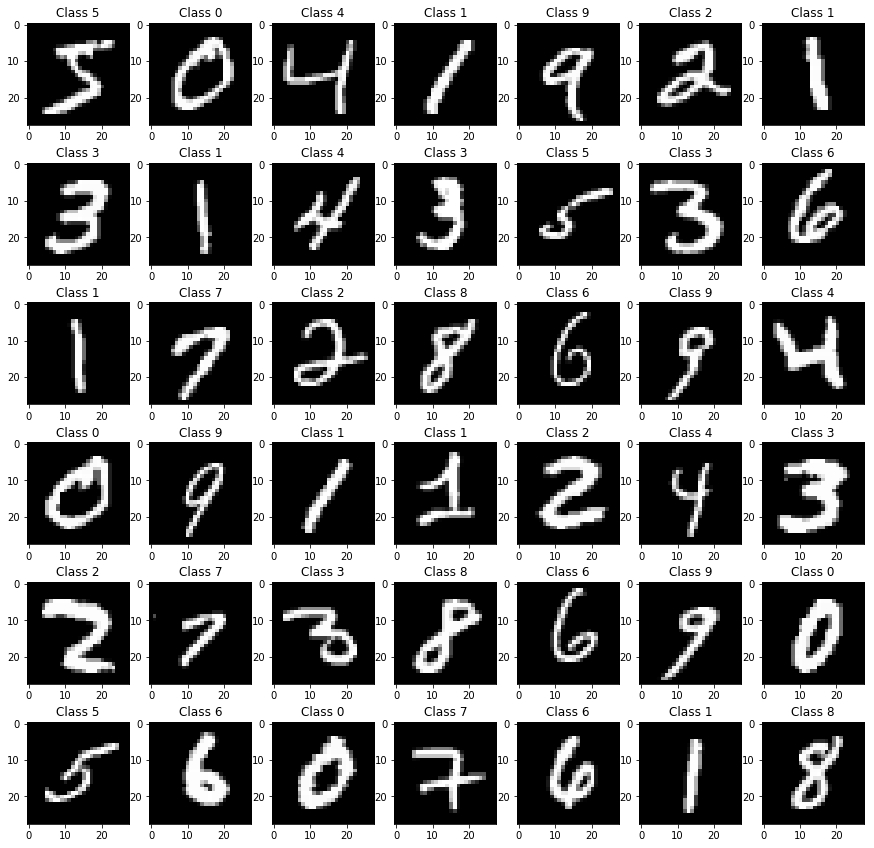

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 15))
for i in range(0,size):
    plt.subplot(6, 7, i + 1)

    pixels = np.array(mnist.validation.images[i], dtype='float32')
    pixels = pixels.reshape((28, 28))

    plt.title('Class {label}'.format(label=labels[i]))
    plt.imshow(pixels, cmap='gray')
    
plt.show()